# 3 Bus (2 Generators, 1 Load) Fault SP vs DP

## Run C++ examples

In [2]:
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import TimeSeries as ts
import matplotlib.pyplot as plt
import re
import numpy as np
import math
import sys
sys.path.insert(0,'/home/mmo-kra/git/dpsim/build')
import dpsimpy

#%matplotlib widget

## DP Simulation

### Parameters

In [3]:
#-----------Power system-----------
#Voltage level as Base Voltage
V_nom = 230e3
nom_freq = 60
nom_omega = nom_freq * 2 * np.pi

#-----------Generator 1 (bus1)-----------
#Machine parameters
nom_power_G1 = 300e6
nom_ph_ph_volt_RMS_G1=25e3
nom_freq_G1 = 60
H_G1 = 6
Xpd_G1 = 0.3 # in p.u
Rs_G1 = 0
Kd_G1 = 1.5
# Initialization parameters 
init_active_power_G1 = 270e6
init_mech_power_G1 = 270e6
set_point_voltage_G1 = nom_ph_ph_volt_RMS_G1 * 1.05

#-----------Generator 2 (bus2)-----------
#Machine parameters
nom_power_G2 = 50e6
nom_ph_ph_volt_RMS_G2=13.8e3
nom_freq_G2 = 60
H_G2 = 2
Xpd_G2 = 0.1 # in p.u
Rs_G2 = 0
Kd_G2 = 1.5
# Initialization parameters 
init_active_power_G2 = 45e6
init_mech_power_G2 = 45e6
set_point_voltage_G2 = nom_ph_ph_volt_RMS_G2 * 0.95

#-----------Transformers-----------
t1_ratio = V_nom / nom_ph_ph_volt_RMS_G1
t2_ratio = V_nom / nom_ph_ph_volt_RMS_G2

#-----------Load (bus3)-----------
active_power_L = 310e6
reactive_power_L = 150e6

#-----------Transmission Lines-----------
#PiLine parameters
#line 1-2 (180km)
line_resistance12 = 1.27e-4 * 529 *180
line_inductance12 = 9.05e-4 * 529 / nom_omega *180
line_capacitance12 = (1.81e-3 / 529) / nom_omega *180
line_conductance12 = 0
#line 1-3 (150km)
line_resistance13 = 1.27e-4 * 529 *150
line_inductance13 = 9.05e-4 * 529 / nom_omega *150
line_capacitance13 = (1.81e-3 / 529) / nom_omega *150
line_conductance13 = 0
#line 2-3 (80km)
line_resistance23 = 1.27e-4 * 529 *80
line_inductance23 = 9.05e-4 * 529 / nom_omega *80
line_capacitance23 = (1.81e-3 / 529) / nom_omega *80
line_conductance23 = 0

#Switch to trigger fault at generator terminal
switch_open = 1e12
switch_closed = 0.1

#Simulation parameters
sim_name="DP_SynGenTrStab_3Bus_Fault"
final_time = 30
time_step = 0.001
start_fault_event=True
end_fault_event=True
start_time_fault=10
end_time_fault=10.2
cmd_inertia_G1 = 1
cmd_inertia_G2 = 1
cmd_damping_G1 = 1
cmd_damping_G2 = 1

### Powerflow for Initialization

In [4]:
time_step_pf = final_time
final_time_pf = final_time + time_step_pf
sim_name_pf = sim_name + "_PF"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_pf)

#Components
n1_pf = dpsimpy.sp.SimNode("n1", dpsimpy.PhaseType.Single)
n2_pf = dpsimpy.sp.SimNode("n2", dpsimpy.PhaseType.Single)
n3_pf = dpsimpy.sp.SimNode("n3", dpsimpy.PhaseType.Single)

#Synchronous generator 1
gen1_pf = dpsimpy.sp.ph1.SynchronGenerator("Generator", dpsimpy.LogLevel.debug)
#setPointVoltage is defined as the voltage at the transfomer primary side and should be transformed to network side
gen1_pf.set_parameters(nom_power_G1, nom_ph_ph_volt_RMS_G1, init_active_power_G1,
                       set_point_voltage_G1 * t1_ratio, dpsimpy.PowerflowBusType.VD)
gen1_pf.set_base_voltage(V_nom)

#Synchronous generator 2
gen2_pf = dpsimpy.sp.ph1.SynchronGenerator("Generator", dpsimpy.LogLevel.debug)
#setPointVoltage is defined as the voltage at the transfomer primary side and should be transformed to network side
gen2_pf.set_parameters(nom_power_G2, nom_ph_ph_volt_RMS_G2, init_active_power_G2,
                       set_point_voltage_G2 * t2_ratio, dpsimpy.PowerflowBusType.PV)
gen2_pf.set_base_voltage(V_nom)

#use Shunt as Load for powerflow
load_pf = dpsimpy.sp.ph1.Shunt("Load", dpsimpy.LogLevel.debug)
load_pf.set_parameters(active_power_L / V_nom**2, - reactive_power_L / V_nom**2)
load_pf.set_base_voltage(V_nom)

#Line12
line12_pf = dpsimpy.sp.ph1.PiLine("PiLine12", dpsimpy.LogLevel.debug)
line12_pf.set_parameters(line_resistance12, line_inductance12, line_capacitance12, line_conductance12)
line12_pf.set_base_voltage(V_nom)

#Line13
line13_pf = dpsimpy.sp.ph1.PiLine("PiLine13", dpsimpy.LogLevel.debug)
line13_pf.set_parameters(line_resistance13, line_inductance13, line_capacitance13, line_conductance13)
line13_pf.set_base_voltage(V_nom)

#Line23
line23_pf = dpsimpy.sp.ph1.PiLine("PiLine23", dpsimpy.LogLevel.debug)
line23_pf.set_parameters(line_resistance23, line_inductance23, line_capacitance23, line_conductance23)
line23_pf.set_base_voltage(V_nom)

# Switch
fault_pf = dpsimpy.sp.ph1.Switch("Br_fault", dpsimpy.LogLevel.debug)
fault_pf.set_parameters(switch_open, switch_closed)
fault_pf.open()

# Topology
gen1_pf.connect([n1_pf])
gen2_pf.connect([n2_pf])
load_pf.connect([n3_pf])
line12_pf.connect([n1_pf, n2_pf])
line13_pf.connect([n1_pf, n3_pf])
line23_pf.connect([n2_pf, n3_pf])
fault_pf.connect([dpsimpy.sp.SimNode.gnd, n2_pf]) # terminal of generator 2
system_pf = dpsimpy.SystemTopology(60, [n1_pf, n2_pf, n3_pf], [gen1_pf, gen2_pf, load_pf, line12_pf, line13_pf, line23_pf, fault_pf])

# Logging
logger_pf = dpsimpy.Logger(sim_name_pf)
logger_pf.log_attribute("v_bus1", "v", n1_pf)
logger_pf.log_attribute("v_bus2", "v", n2_pf)
logger_pf.log_attribute("v_bus3", "v", n3_pf)

# Simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(time_step_pf)
sim_pf.set_final_time(final_time_pf)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.add_logger(logger_pf)
sim_pf.run()

[20:18:35.824945 PiLine12 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:35.825305 PiLine13 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:35.825637 PiLine23 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:35.827996 DP_SynGenTrStab_3Bus_Fault_PF info] Initialize simulation: DP_SynGenTrStab_3Bus_Fault_PF
[20:18:35.828322 DP_SynGenTrStab_3Bus_Fault_PF_PF_Solver warning] Unable to get base voltage at n3
[20:18:35.828536 DP_SynGenTrStab_3Bus_Fault_PF info] Scheduling tasks.
[20:18:35.828780 DP_SynGenTrStab_3Bus_Fault_PF info] Scheduling done.
[20:18:35.828783 DP_SynGenTrStab_3Bus_Fault_PF info] Opening interfaces.
[20:18:35.828785 DP_SynGenTrStab_3Bus_Fault_PF info] Start synchronization with remotes on interfaces
[20:18:35.828787 DP_SynGenTrStab_3Bus_Fault_PF info] Synchronized simulation start with remotes
[20:18:35.828789 DP_SynGenTrStab_3Bus_Fault_PF info] Start simulation: DP_SynGenTrS

### Dynamic Simulation

In [5]:
sim_name_dp = sim_name + "_DP"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_dp)

#Components
n1_dp = dpsimpy.dp.SimNode("n1", dpsimpy.PhaseType.Single)
n2_dp = dpsimpy.dp.SimNode("n2", dpsimpy.PhaseType.Single)
n3_dp = dpsimpy.dp.SimNode("n3", dpsimpy.PhaseType.Single)

#Synchronous generator 1
gen1_dp = dpsimpy.dp.ph1.SynchronGeneratorTrStab("SynGen1", dpsimpy.LogLevel.debug)
# Xpd is given in p.u of generator base at transfomer primary side and should be transformed to network side
gen1_dp.set_standard_parameters_PU(nom_power_G1, nom_ph_ph_volt_RMS_G1, nom_freq_G1,
                                  Xpd_G1 * t1_ratio**2, cmd_inertia_G1 * H_G1, Rs_G1,
                                  cmd_damping_G1 * Kd_G1)
init_apparent_power_G1 = gen1_pf.get_apparent_power()
gen1_dp.set_initial_values(init_apparent_power_G1, init_mech_power_G1)

#Synchronous generator 2
gen2_dp = dpsimpy.dp.ph1.SynchronGeneratorTrStab("SynGen2", dpsimpy.LogLevel.debug)
# Xpd is given in p.u of generator base at transfomer primary side and should be transformed to network side
gen2_dp.set_standard_parameters_PU(nom_power_G2, nom_ph_ph_volt_RMS_G2, nom_freq_G2,
                                  Xpd_G2 * t2_ratio**2, cmd_inertia_G2 * H_G2, Rs_G2,
                                  cmd_damping_G2 * Kd_G2)
init_apparent_power_G2 = gen2_pf.get_apparent_power()
gen2_dp.set_initial_values(init_apparent_power_G2, init_mech_power_G2)
gen2_dp.set_model_flags(convert_with_omega_mech=True)
gen2_dp.set_reference_omega("w_r", gen1_dp, "delta_r", gen1_dp)

# Load
load_dp = dpsimpy.dp.ph1.RXLoad("Load", dpsimpy.LogLevel.debug)
load_dp.set_parameters(active_power_L, reactive_power_L, V_nom)

#Line12
line12_dp = dpsimpy.dp.ph1.PiLine("PiLine12", dpsimpy.LogLevel.debug)
line12_dp.set_parameters(line_resistance12, line_inductance12, line_capacitance12, line_conductance12)

#Line13
line13_dp = dpsimpy.dp.ph1.PiLine("PiLine13", dpsimpy.LogLevel.debug)
line13_dp.set_parameters(line_resistance13, line_inductance13, line_capacitance13, line_conductance13)

#Line23
line23_dp = dpsimpy.dp.ph1.PiLine("PiLine23", dpsimpy.LogLevel.debug)
line23_dp.set_parameters(line_resistance23, line_inductance23, line_capacitance23, line_conductance23)

# Switch
fault_dp = dpsimpy.dp.ph1.varResSwitch("Br_fault", dpsimpy.LogLevel.debug)
fault_dp.set_parameters(switch_open, switch_closed)
fault_dp.set_init_parameters(time_step)
fault_dp.open()

# Topology
gen1_dp.connect([n1_dp])
gen2_dp.connect([n2_dp])
load_dp.connect([n3_dp])
line12_dp.connect([n1_dp, n2_dp])
line13_dp.connect([n1_dp, n3_dp])
line23_dp.connect([n2_dp, n3_dp])
fault_dp.connect([dpsimpy.dp.SimNode.gnd, n2_dp]) # terminal of generator 2
system_dp = dpsimpy.SystemTopology(60, [n1_dp, n2_dp, n3_dp], [gen1_dp, gen2_dp, load_dp, line12_dp, line13_dp, line23_dp, fault_dp])

# Initialization of dynamic topology
system_dp.init_with_powerflow(system_pf)

# Logging
logger_dp = dpsimpy.Logger(sim_name_dp)
logger_dp.log_attribute("v1", "v", n1_dp)
logger_dp.log_attribute("v2", "v", n2_dp)
logger_dp.log_attribute("v3", "v", n3_dp)

logger_dp.log_attribute("v_line12", "v_intf", line12_dp)
logger_dp.log_attribute("v_line13", "v_intf", line13_dp)
logger_dp.log_attribute("v_line23", "v_intf", line23_dp)
logger_dp.log_attribute("i_line12", "i_intf", line12_dp)
logger_dp.log_attribute("i_line13", "i_intf", line13_dp)
logger_dp.log_attribute("i_line23", "i_intf", line23_dp)

logger_dp.log_attribute("Ep_gen1", "Ep_mag", gen1_dp)
logger_dp.log_attribute("v_gen1", "v_intf", gen1_dp)
logger_dp.log_attribute("i_gen1", "i_intf", gen1_dp)
logger_dp.log_attribute("wr_gen1", "w_r", gen1_dp)
logger_dp.log_attribute("delta_gen1", "delta_r", gen1_dp)
logger_dp.log_attribute("P_mech1", "P_mech", gen1_dp)
logger_dp.log_attribute("P_elec1", "P_elec", gen1_dp)

logger_dp.log_attribute("Ep_gen2", "Ep_mag", gen2_dp)
logger_dp.log_attribute("v_gen2", "v_intf", gen2_dp)
logger_dp.log_attribute("i_gen2", "i_intf", gen2_dp)
logger_dp.log_attribute("wr_gen2", "w_r", gen2_dp)
logger_dp.log_attribute("delta_gen2", "delta_r", gen2_dp)
logger_dp.log_attribute("wref_gen2", "w_ref", gen2_dp)
logger_dp.log_attribute("P_mech2", "P_mech", gen2_dp)
logger_dp.log_attribute("P_elec2", "P_elec", gen2_dp)

logger_dp.log_attribute("i_fault", "i_intf", fault_dp)
logger_dp.log_attribute("v_load", "v_intf", load_dp)
logger_dp.log_attribute("i_load", "i_intf", load_dp)

# Simulation
sim_dp = dpsimpy.Simulation(sim_name_dp, dpsimpy.LogLevel.debug)
sim_dp.set_system(system_dp)
sim_dp.set_time_step(time_step)
sim_dp.set_final_time(final_time)
sim_dp.set_domain(dpsimpy.Domain.DP)
sim_dp.add_logger(logger_dp)
sim_dp.do_system_matrix_recomputation(True)
sim_dp.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)


# Events
if start_fault_event:
    sw1 = dpsimpy.event.SwitchEvent(start_time_fault, fault_dp, True)
    sim_dp.add_event(sw1)
    
if end_fault_event:
    sw2 = dpsimpy.event.SwitchEvent(end_time_fault, fault_dp, False)
    sim_dp.add_event(sw2)

sim_dp.run()

1.000000e+01: Handle event time


[20:18:35.863864 DP_SynGenTrStab_3Bus_Fault_DP info] Initialize simulation: DP_SynGenTrStab_3Bus_Fault_DP
[20:18:35.864034 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[20:18:35.868721 DP_SynGenTrStab_3Bus_Fault_DP_Solver warning] Linear solver configuration is not used!
[20:18:35.871816 DP_SynGenTrStab_3Bus_Fault_DP info] Scheduling tasks.
[20:18:35.872736 DP_SynGenTrStab_3Bus_Fault_DP info] Scheduling done.
[20:18:35.872740 DP_SynGenTrStab_3Bus_Fault_DP info] Opening interfaces.
[20:18:35.872742 DP_SynGenTrStab_3Bus_Fault_DP info] Start synchronization with remotes on interfaces
[20:18:35.872744 DP_SynGenTrStab_3Bus_Fault_DP info] Synchronized simulation start with remotes
[20:18:35.872747 DP_SynGenTrStab_3Bus_Fault_DP info] Start simulation: DP_SynGenTrStab_3Bus_Fault_DP
[20:18:35.872751 DP_SynGenTrStab_3Bus_Fault_DP info] Time step: 1.000000e-03
[20:18:35.872753 DP_SynGenTrStab_3Bus_Fault_DP info] Final time: 3.000000e+01
[20:18:42.305870 DP_SynGenTrStab_3B

1.020000e+01: Handle event time


## SP Simulation

### Parameters

In [6]:
#-----------Power system-----------
#Voltage level as Base Voltage
V_nom = 230e3
nom_freq = 60
nom_omega = nom_freq * 2 * np.pi

#-----------Generator 1 (bus1)-----------
#Machine parameters
nom_power_G1 = 300e6
nom_ph_ph_volt_RMS_G1=25e3
nom_freq_G1 = 60
H_G1 = 6
Xpd_G1 = 0.3 # in p.u
Rs_G1 = 0
Kd_G1 = 1.5
# Initialization parameters 
init_active_power_G1 = 270e6
init_mech_power_G1 = 270e6
set_point_voltage_G1 = nom_ph_ph_volt_RMS_G1 * 1.05

#-----------Generator 2 (bus2)-----------
#Machine parameters
nom_power_G2 = 50e6
nom_ph_ph_volt_RMS_G2=13.8e3
nom_freq_G2 = 60
H_G2 = 2
Xpd_G2 = 0.1 # in p.u
Rs_G2 = 0
Kd_G2 = 1.5
# Initialization parameters 
init_active_power_G2 = 45e6
init_mech_power_G2 = 45e6
set_point_voltage_G2 = nom_ph_ph_volt_RMS_G2 * 0.95

#-----------Transformers-----------
t1_ratio = V_nom / nom_ph_ph_volt_RMS_G1
t2_ratio = V_nom / nom_ph_ph_volt_RMS_G2

#-----------Load (bus3)-----------
active_power_L = 310e6
reactive_power_L = 150e6

#-----------Transmission Lines-----------
#PiLine parameters
#line 1-2 (180km)
line_resistance12 = 1.27e-4 * 529 *180
line_inductance12 = 9.05e-4 * 529 / nom_omega *180
line_capacitance12 = (1.81e-3 / 529) / nom_omega *180
line_conductance12 = 0
#line 1-3 (150km)
line_resistance13 = 1.27e-4 * 529 *150
line_inductance13 = 9.05e-4 * 529 / nom_omega *150
line_capacitance13 = (1.81e-3 / 529) / nom_omega *150
line_conductance13 = 0
#line 2-3 (80km)
line_resistance23 = 1.27e-4 * 529 *80
line_inductance23 = 9.05e-4 * 529 / nom_omega *80
line_capacitance23 = (1.81e-3 / 529) / nom_omega *80
line_conductance23 = 0

#Switch to trigger fault at generator terminal
switch_open = 1e12
switch_closed = 0.1

#Simulation parameters
sim_name="SP_SynGenTrStab_3Bus_Fault"
final_time = 30
time_step = 0.001
start_fault_event=True
end_fault_event=True
start_time_fault=10
end_time_fault=10.2
cmd_inertia_G1 = 1
cmd_inertia_G2 = 1
cmd_damping_G1 = 1
cmd_damping_G2 = 1

### Powerflow for Initialization

In [7]:
time_step_pf = final_time
final_time_pf = final_time + time_step_pf
sim_name_pf = sim_name + "_PF"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_pf)

#Components
n1_pf = dpsimpy.sp.SimNode("n1", dpsimpy.PhaseType.Single)
n2_pf = dpsimpy.sp.SimNode("n2", dpsimpy.PhaseType.Single)
n3_pf = dpsimpy.sp.SimNode("n3", dpsimpy.PhaseType.Single)

#Synchronous generator 1
gen1_pf = dpsimpy.sp.ph1.SynchronGenerator("Generator", dpsimpy.LogLevel.debug)
#setPointVoltage is defined as the voltage at the transfomer primary side and should be transformed to network side
gen1_pf.set_parameters(nom_power_G1, nom_ph_ph_volt_RMS_G1, init_active_power_G1,
                       set_point_voltage_G1 * t1_ratio, dpsimpy.PowerflowBusType.VD)
gen1_pf.set_base_voltage(V_nom)

#Synchronous generator 2
gen2_pf = dpsimpy.sp.ph1.SynchronGenerator("Generator", dpsimpy.LogLevel.debug)
#setPointVoltage is defined as the voltage at the transfomer primary side and should be transformed to network side
gen2_pf.set_parameters(nom_power_G2, nom_ph_ph_volt_RMS_G2, init_active_power_G2,
                       set_point_voltage_G2 * t2_ratio, dpsimpy.PowerflowBusType.PV)
gen2_pf.set_base_voltage(V_nom)

#use Shunt as Load for powerflow
load_pf = dpsimpy.sp.ph1.Shunt("Load", dpsimpy.LogLevel.debug)
load_pf.set_parameters(active_power_L / V_nom**2, - reactive_power_L / V_nom**2)
load_pf.set_base_voltage(V_nom)

#Line12
line12_pf = dpsimpy.sp.ph1.PiLine("PiLine12", dpsimpy.LogLevel.debug)
line12_pf.set_parameters(line_resistance12, line_inductance12, line_capacitance12, line_conductance12)
line12_pf.set_base_voltage(V_nom)

#Line13
line13_pf = dpsimpy.sp.ph1.PiLine("PiLine13", dpsimpy.LogLevel.debug)
line13_pf.set_parameters(line_resistance13, line_inductance13, line_capacitance13, line_conductance13)
line13_pf.set_base_voltage(V_nom)

#Line23
line23_pf = dpsimpy.sp.ph1.PiLine("PiLine23", dpsimpy.LogLevel.debug)
line23_pf.set_parameters(line_resistance23, line_inductance23, line_capacitance23, line_conductance23)
line23_pf.set_base_voltage(V_nom)

# Switch
fault_pf = dpsimpy.sp.ph1.Switch("Br_fault", dpsimpy.LogLevel.debug)
fault_pf.set_parameters(switch_open, switch_closed)
fault_pf.open()

# Topology
gen1_pf.connect([n1_pf])
gen2_pf.connect([n2_pf])
load_pf.connect([n3_pf])
line12_pf.connect([n1_pf, n2_pf])
line13_pf.connect([n1_pf, n3_pf])
line23_pf.connect([n2_pf, n3_pf])
fault_pf.connect([dpsimpy.sp.SimNode.gnd, n2_pf]) # terminal of generator 2
system_pf = dpsimpy.SystemTopology(60, [n1_pf, n2_pf, n3_pf], [gen1_pf, gen2_pf, load_pf, line12_pf, line13_pf, line23_pf, fault_pf])

# Logging
logger_pf = dpsimpy.Logger(sim_name_pf)
logger_pf.log_attribute("v_bus1", "v", n1_pf)
logger_pf.log_attribute("v_bus2", "v", n2_pf)
logger_pf.log_attribute("v_bus3", "v", n3_pf)

# Simulation
sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.debug)
sim_pf.set_system(system_pf)
sim_pf.set_time_step(time_step_pf)
sim_pf.set_final_time(final_time_pf)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.do_init_from_nodes_and_terminals(False)
sim_pf.add_logger(logger_pf)
sim_pf.run()

[20:18:42.358380 PiLine12 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:42.358772 PiLine13 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:42.359128 PiLine23 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:42.362110 SP_SynGenTrStab_3Bus_Fault_PF info] Initialize simulation: SP_SynGenTrStab_3Bus_Fault_PF
[20:18:42.362523 SP_SynGenTrStab_3Bus_Fault_PF_PF_Solver warning] Unable to get base voltage at n3
[20:18:42.362717 SP_SynGenTrStab_3Bus_Fault_PF info] Scheduling tasks.
[20:18:42.362948 SP_SynGenTrStab_3Bus_Fault_PF info] Scheduling done.
[20:18:42.362951 SP_SynGenTrStab_3Bus_Fault_PF info] Opening interfaces.
[20:18:42.362953 SP_SynGenTrStab_3Bus_Fault_PF info] Start synchronization with remotes on interfaces
[20:18:42.362955 SP_SynGenTrStab_3Bus_Fault_PF info] Synchronized simulation start with remotes
[20:18:42.362958 SP_SynGenTrStab_3Bus_Fault_PF info] Start simulation: SP_SynGenTrS

### Dynamic Simulation

In [8]:
sim_name_sp = sim_name + "_SP"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_sp)

#Components
n1_sp = dpsimpy.sp.SimNode("n1", dpsimpy.PhaseType.Single)
n2_sp = dpsimpy.sp.SimNode("n2", dpsimpy.PhaseType.Single)
n3_sp = dpsimpy.sp.SimNode("n3", dpsimpy.PhaseType.Single)

#Synchronous generator 1
gen1_sp = dpsimpy.sp.ph1.SynchronGeneratorTrStab("SynGen", dpsimpy.LogLevel.debug)
# Xpd is given in p.u of generator base at transfomer primary side and should be transformed to network side
gen1_sp.set_standard_parameters_PU(nom_power_G1, nom_ph_ph_volt_RMS_G1, nom_freq_G1,
                                  Xpd_G1 * t1_ratio**2, cmd_inertia_G1 * H_G1, Rs_G1,
                                  cmd_damping_G1 * Kd_G1)
init_apparent_power_G1 = gen1_pf.get_apparent_power()
gen1_sp.set_initial_values(init_apparent_power_G1, init_mech_power_G1)

#Synchronous generator 2
gen2_sp = dpsimpy.sp.ph1.SynchronGeneratorTrStab("SynGen", dpsimpy.LogLevel.debug)
# Xpd is given in p.u of generator base at transfomer primary side and should be transformed to network side
gen2_sp.set_standard_parameters_PU(nom_power_G2, nom_ph_ph_volt_RMS_G2, nom_freq_G2,
                                  Xpd_G2 * t2_ratio**2, cmd_inertia_G2 * H_G2, Rs_G2,
                                  cmd_damping_G2 * Kd_G2)
init_apparent_power_G2 = gen2_pf.get_apparent_power()
gen2_sp.set_initial_values(init_apparent_power_G2, init_mech_power_G2)
gen2_sp.set_model_flags(convert_with_omega_mech=True)
gen2_sp.set_reference_omega("w_r", gen1_sp, "delta_r", gen1_sp)

# Load
load_sp = dpsimpy.sp.ph1.Load("Load", dpsimpy.LogLevel.debug)
load_sp.set_parameters(active_power_L, reactive_power_L, V_nom)

#Line12
line12_sp = dpsimpy.sp.ph1.PiLine("PiLine12", dpsimpy.LogLevel.debug)
line12_sp.set_parameters(line_resistance12, line_inductance12, line_capacitance12, line_conductance12)

#Line13
line13_sp = dpsimpy.sp.ph1.PiLine("PiLine13", dpsimpy.LogLevel.debug)
line13_sp.set_parameters(line_resistance13, line_inductance13, line_capacitance13, line_conductance13)

#Line23
line23_sp = dpsimpy.sp.ph1.PiLine("PiLine23", dpsimpy.LogLevel.debug)
line23_sp.set_parameters(line_resistance23, line_inductance23, line_capacitance23, line_conductance23)

# Switch
fault_sp = dpsimpy.sp.ph1.varResSwitch("Br_fault", dpsimpy.LogLevel.debug)
fault_sp.set_parameters(switch_open, switch_closed)
fault_sp.set_init_parameters(time_step)
fault_sp.open()

# Topology
gen1_sp.connect([n1_sp])
gen2_sp.connect([n2_sp])
load_sp.connect([n3_sp])
line12_sp.connect([n1_sp, n2_sp])
line13_sp.connect([n1_sp, n3_sp])
line23_sp.connect([n2_sp, n3_sp])
fault_sp.connect([dpsimpy.sp.SimNode.gnd, n2_sp]) # terminal of generator 2
system_sp = dpsimpy.SystemTopology(60, [n1_sp, n2_sp, n3_sp], [gen1_sp, gen2_sp, load_sp, line12_sp, line13_sp, line23_sp, fault_sp])

# Initialization of dynamic topology
system_sp.init_with_powerflow(system_pf)

# Logging
logger_sp = dpsimpy.Logger(sim_name_sp)
logger_sp.log_attribute("v1", "v", n1_sp)
logger_sp.log_attribute("v2", "v", n2_sp)
logger_sp.log_attribute("v3", "v", n3_sp)

logger_sp.log_attribute("v_line12", "v_intf", line12_sp)
logger_sp.log_attribute("v_line13", "v_intf", line13_sp)
logger_sp.log_attribute("v_line23", "v_intf", line23_sp)
logger_sp.log_attribute("i_line12", "i_intf", line12_sp)
logger_sp.log_attribute("i_line13", "i_intf", line13_sp)
logger_sp.log_attribute("i_line23", "i_intf", line23_sp)

logger_sp.log_attribute("Ep_gen1", "Ep_mag", gen1_sp)
logger_sp.log_attribute("v_gen1", "v_intf", gen1_sp)
logger_sp.log_attribute("i_gen1", "i_intf", gen1_sp)
logger_sp.log_attribute("wr_gen1", "w_r", gen1_sp)
logger_sp.log_attribute("delta_gen1", "delta_r", gen1_sp)
logger_sp.log_attribute("P_mech1", "P_mech", gen1_sp)
logger_sp.log_attribute("P_elec1", "P_elec", gen1_sp)

logger_sp.log_attribute("Ep_gen2", "Ep_mag", gen2_sp)
logger_sp.log_attribute("v_gen2", "v_intf", gen2_sp)
logger_sp.log_attribute("i_gen2", "i_intf", gen2_sp)
logger_sp.log_attribute("wr_gen2", "w_r", gen2_sp)
logger_sp.log_attribute("delta_gen2", "delta_r", gen2_sp)
logger_sp.log_attribute("wref_gen2", "w_ref", gen2_sp)
logger_sp.log_attribute("P_mech2", "P_mech", gen2_sp)
logger_sp.log_attribute("P_elec2", "P_elec", gen2_sp)

logger_sp.log_attribute("i_fault", "i_intf", fault_sp)
logger_sp.log_attribute("v_load", "v_intf", load_sp)
logger_sp.log_attribute("i_load", "i_intf", load_sp)

# Simulation
sim_sp = dpsimpy.Simulation(sim_name_sp, dpsimpy.LogLevel.debug)
sim_sp.set_system(system_sp)
sim_sp.set_time_step(time_step)
sim_sp.set_final_time(final_time)
sim_sp.set_domain(dpsimpy.Domain.SP)
sim_sp.add_logger(logger_sp)
sim_sp.do_system_matrix_recomputation(True)
sim_sp.set_direct_solver_implementation(dpsimpy.DirectLinearSolverImpl.SparseLU)


# Events
if start_fault_event:
    sw1 = dpsimpy.event.SwitchEvent(start_time_fault, fault_sp, True)
    sim_sp.add_event(sw1)
    
if end_fault_event:
    sw2 = dpsimpy.event.SwitchEvent(end_time_fault, fault_sp, False)
    sim_sp.add_event(sw2)

sim_sp.run()

1.000000e+01: Handle event time
1.020000e+01: Handle event time


[20:18:42.388464 PiLine12 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:42.388817 PiLine13 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:42.389130 PiLine23 warning] Zero value for Conductance, setting default value of G=1e-06 [S]
[20:18:42.392811 SP_SynGenTrStab_3Bus_Fault_SP info] Initialize simulation: SP_SynGenTrStab_3Bus_Fault_SP
[20:18:42.393013 MnaSolverFactory info] creating SparseLUAdapter solver implementation
[20:18:42.403419 SP_SynGenTrStab_3Bus_Fault_SP_Solver warning] Linear solver configuration is not used!
[20:18:42.406249 SP_SynGenTrStab_3Bus_Fault_SP info] Scheduling tasks.
[20:18:42.407031 SP_SynGenTrStab_3Bus_Fault_SP info] Scheduling done.
[20:18:42.407035 SP_SynGenTrStab_3Bus_Fault_SP info] Opening interfaces.
[20:18:42.407037 SP_SynGenTrStab_3Bus_Fault_SP info] Start synchronization with remotes on interfaces
[20:18:42.407038 SP_SynGenTrStab_3Bus_Fault_SP info] Synchronized simulation start with

## SP Results

In [9]:
work_dir = 'logs/SP_SynGenTrStab_3Bus_Fault_SP/'
log_name = 'SP_SynGenTrStab_3Bus_Fault_SP'
print(work_dir + log_name + '.csv')
ts_sp1ph_TrStab_dl= rt.read_timeseries_dpsim(work_dir + log_name + '.csv')

logs/SP_SynGenTrStab_3Bus_Fault_SP/SP_SynGenTrStab_3Bus_Fault_SP.csv
column number: 27
results length: 30000
real column names: ['Ep_gen1', 'Ep_gen2', 'P_elec1', 'P_elec2', 'P_mech1', 'P_mech2', 'delta_gen1', 'delta_gen2', 'wr_gen1', 'wr_gen2', 'wref_gen2']
complex column names: ['i_fault', 'i_gen1', 'i_gen2', 'i_line12', 'i_line13', 'i_line23', 'i_load', 'v1', 'v2', 'v3', 'v_gen1', 'v_gen2', 'v_line12', 'v_line13', 'v_line23', 'v_load']


## DP Results

In [10]:
work_dir = 'logs/DP_SynGenTrStab_3Bus_Fault_DP/'
log_name = 'DP_SynGenTrStab_3Bus_Fault_DP'
print(work_dir + log_name + '.csv')
ts_dp1ph_TrStab_dl = rt.read_timeseries_dpsim(work_dir + log_name + '.csv')

logs/DP_SynGenTrStab_3Bus_Fault_DP/DP_SynGenTrStab_3Bus_Fault_DP.csv
column number: 27
results length: 30000
real column names: ['Ep_gen1', 'Ep_gen2', 'P_elec1', 'P_elec2', 'P_mech1', 'P_mech2', 'delta_gen1', 'delta_gen2', 'wr_gen1', 'wr_gen2', 'wref_gen2']
complex column names: ['i_fault', 'i_gen1', 'i_gen2', 'i_line12', 'i_line13', 'i_line23', 'i_load', 'v1', 'v2', 'v3', 'v_gen1', 'v_gen2', 'v_line12', 'v_line13', 'v_line23', 'v_load']


## Generator 1&2 terminal voltage

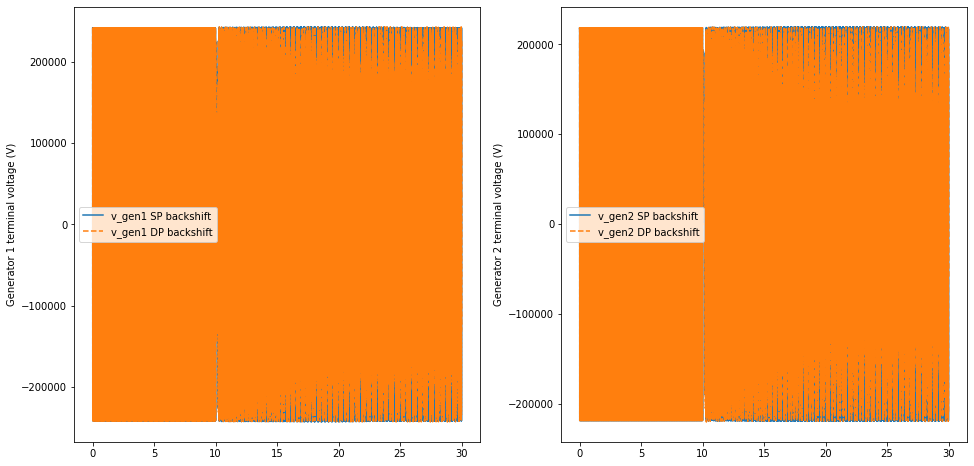

In [11]:
timestep=50e-6
t_begin=0
t_end=30

begin_idx = int(t_begin/timestep)
end_idx= int(t_end/timestep)

f= plt.figure(figsize=(16,8))

f.add_subplot(1, 2, 1)
plt.ylabel('Generator 1 terminal voltage (V)')

for name in ['v_gen1']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' DP backshift', linestyle='--')
plt.legend()

f.add_subplot(1, 2, 2)
plt.ylabel('Generator 2 terminal voltage (V)')

for name in ['v_gen2']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' DP backshift', linestyle='--')
plt.legend()

f.show()

## Generator 1&2 terminal Current

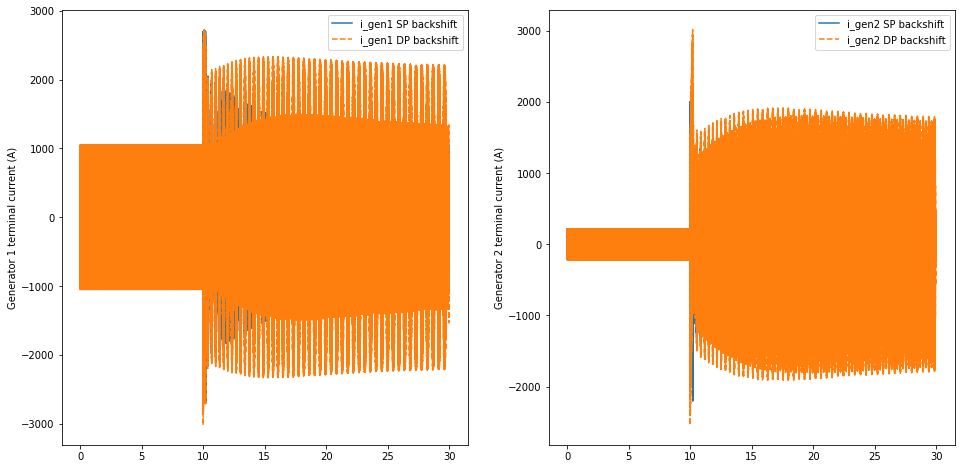

In [12]:
f= plt.figure(figsize=(16,8))

f.add_subplot(1, 2, 1)
plt.ylabel('Generator 1 terminal current (A)')

for name in ['i_gen1']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' DP backshift', linestyle='--')
plt.legend()

f.add_subplot(1, 2, 2)
plt.ylabel('Generator 2 terminal current (A)')

for name in ['i_gen2']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).frequency_shift(60).values[begin_idx:end_idx], label=name + ' DP backshift', linestyle='--')
plt.legend()

f.show()

## Generator 1&2 Rotor frequency

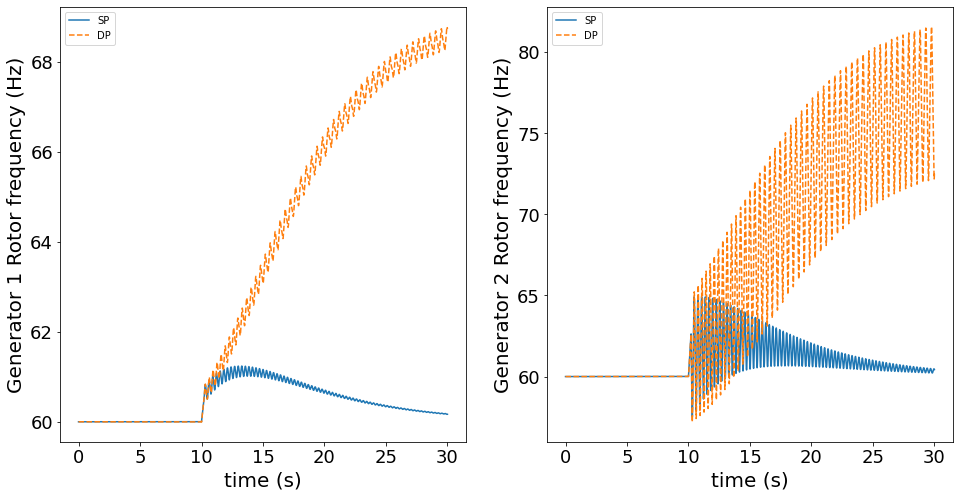

In [13]:
f= plt.figure(figsize=(16,8))

f.add_subplot(1, 2, 1)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('Generator 1 Rotor frequency (Hz)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(55,65)

for name in ['wr_gen1']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*60/377, label='SP')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*60/377, label='DP', linestyle='--')
plt.legend()

f.add_subplot(1, 2, 2)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('Generator 2 Rotor frequency (Hz)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(55,65)

for name in ['wr_gen2']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*60/377, label='SP')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*60/377, label='DP', linestyle='--')
plt.legend()

f.show()

## Generator 1&2 Rotor angular velocity $\omega _r$

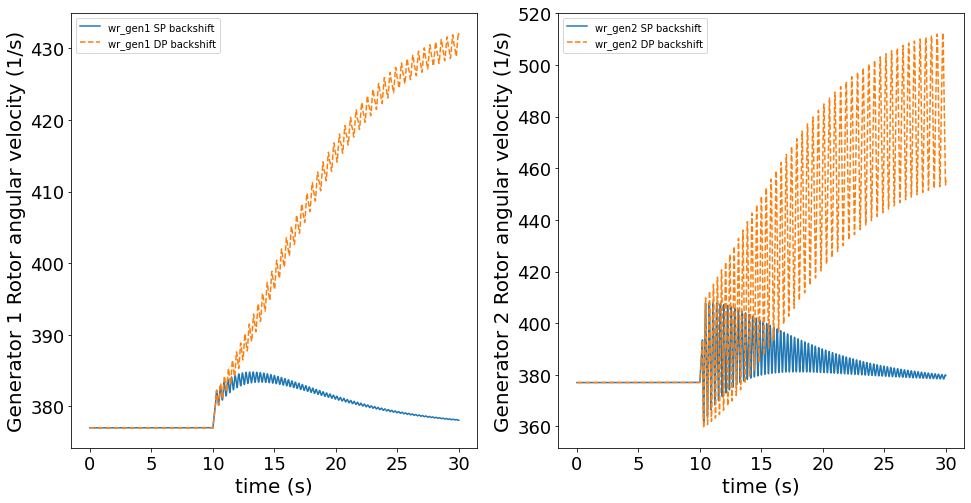

In [14]:
f= plt.figure(figsize=(16,8))

f.add_subplot(1, 2, 1)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('Generator 1 Rotor angular velocity (1/s)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(360,400)

for name in ['wr_gen1']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx], label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx], label=name + ' DP backshift', linestyle='--')
plt.legend()

f.add_subplot(1, 2, 2)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('Generator 2 Rotor angular velocity (1/s)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(360,400)

for name in ['wr_gen2']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx], label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx], label=name + ' DP backshift', linestyle='--')
plt.legend()

f.show()

## Generator 1&2 Rotor angle $\delta _r$

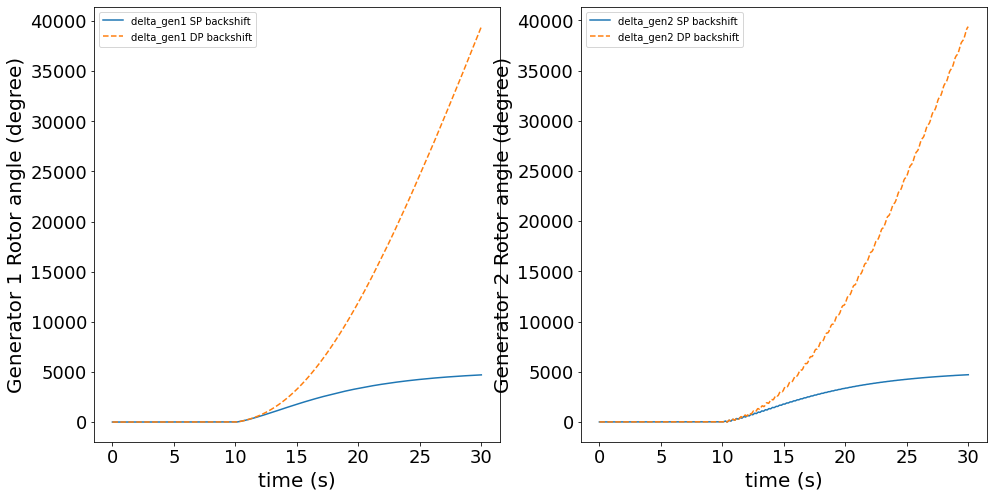

In [15]:
f= plt.figure(figsize=(16,8))

f.add_subplot(1, 2, 1)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('Generator 1 Rotor angle (degree)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-20,20)

for name in ['delta_gen1']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*180/3.14, label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*180/3.14, label=name + ' DP backshift', linestyle='--')
plt.legend()

f.add_subplot(1, 2, 2)
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('Generator 2 Rotor angle (degree)', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-20,20)

for name in ['delta_gen2']:
    plt.plot(ts_sp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_sp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*180/3.14, label=name + ' SP backshift')
    plt.plot(ts_dp1ph_TrStab_dl[name].interpolate(timestep).time[begin_idx:end_idx], ts_dp1ph_TrStab_dl[name].interpolate(timestep).values[begin_idx:end_idx]*180/3.14, label=name + ' DP backshift', linestyle='--')
plt.legend()

f.show()